In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.color import label2rgb
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K


In [2]:
TRAIN_PATH = 'SHIDC-B-Ki-67/bare images/Train'
TEST_PATH = 'SHIDC-B-Ki-67/bare images/Test'
IMAGE_SIZE = (256, 256)
POINT_SIZE = 3
CLASS_LABELS = ["Tło", "Pozytywne", "Negatywne", "TIL"]

In [3]:
def load_images_and_masks(image_paths, json_paths, image_size=(256, 256), point_size=2):
    images = []
    masks = []

    for img_path, json_path in zip(image_paths, json_paths):
        img = cv2.imread(img_path)
        img = img / 255
        original_size = img.shape[:2] 
        img = cv2.resize(img, image_size)
        images.append(img)


        mask = np.zeros((image_size[0], image_size[1], 4), dtype=np.uint8)
        mask[:, :, 0] = 1 

        try:
            with open(json_path, 'r') as f:
                json_data = json.load(f)
        except Exception as e:
            print(f"Błąd odczytu JSON {json_path}: {e}")
            continue  

        if not isinstance(json_data, list):
            print(f"Nieprawidłowy format JSON w {json_path}, oczekiwano listy!")
            continue

        for item in json_data:
            if 'x' in item and 'y' in item and 'label_id' in item:
                x, y, label = int(item['x']), int(item['y']), int(item['label_id'])

                x = int((x / original_size[1]) * image_size[1])
                y = int((y / original_size[0]) * image_size[0])

                if 0 <= x < image_size[1] and 0 <= y < image_size[0]: 
                    if label == 1:
                        cv2.circle(mask, (x, y), point_size, (0, 1, 0, 0), -1)  
                    elif label == 2:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 1, 0), -1)  
                    elif label == 3:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 0, 1), -1)  

        
        mask[:, :, 0] = (np.sum(mask[:, :, 1:], axis=-1) == 0).astype(np.uint8)

        masks.append(mask)

    return np.array(images), np.array(masks, dtype=np.float32)


def load_files(path):
    images = []
    jsons = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                images.append(os.path.join(root, file))
            elif file.endswith('.json'):
                jsons.append(os.path.join(root, file))
    return images, jsons

In [4]:
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def max_pool(x):
    return layers.MaxPooling2D((2, 2))(x)

def upsample_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(filters, (2, 2), activation='relu', padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x


In [5]:
def unet(input_shape=(256, 256, 3), output_channels=4, filterd_vector=[32, 64, 128, 256, 512]):
    inputs = layers.Input(input_shape)

    conv1 = conv_block(inputs, filterd_vector[0])
    pool1 = max_pool(conv1)

    conv2 = conv_block(pool1, filterd_vector[1])
    pool2 = max_pool(conv2)

    conv3 = conv_block(pool2, filterd_vector[2])
    pool3 = max_pool(conv3)

    conv4 = conv_block(pool3, filterd_vector[3])
    pool4 = max_pool(conv4)

    conv5 = conv_block(pool4, filterd_vector[4])

    up6 = upsample_block(conv5, conv4, filterd_vector[3])
    up7 = upsample_block(up6, conv3, filterd_vector[2])
    up8 = upsample_block(up7, conv2, filterd_vector[1])
    up9 = upsample_block(up8, conv1, filterd_vector[0])

    outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax')(up9)

    return models.Model(inputs, outputs, name="U-Net")


In [6]:
def stacked_unet(input_shape=(256, 256, 3), output_channels=4, filterd_vector=[32, 64, 128, 256, 512], num_unets=2):
    ref_input = layers.Input(input_shape, name="input_image")
    x = ref_input

    for i in range(num_unets):
        print(f"U-Net {i+1}/{num_unets}")

        
        current_unet = unet(input_shape=x.shape[1:], output_channels=output_channels, filterd_vector=filterd_vector)
        current_unet._name = f"U-Net-{i+1}"  

        x = current_unet(x)

        if i < num_unets - 1:
            x = layers.Concatenate(axis=-1)([ref_input, x])  

    return models.Model(ref_input, x, name="Stacked-U-Net")


In [7]:
model = stacked_unet(num_unets=2)
model.summary()


U-Net 1/2
U-Net 2/2
Model: "Stacked-U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 U-Net-1 (Functional)           (None, 256, 256, 4)  7771972     ['input_image[0][0]']            
                                                                                                  
 concatenate_4 (Concatenate)    (None, 256, 256, 7)  0           ['input_image[0][0]',            
                                                                  'U-Net-1[0][0]']                
                                                                  

In [8]:

train_images, train_jsons = load_files(TRAIN_PATH)
test_images, test_jsons = load_files(TEST_PATH)

X_train, Y_train = load_images_and_masks(train_images, train_jsons, image_size=IMAGE_SIZE, point_size=POINT_SIZE)
X_test, Y_test = load_images_and_masks(test_images, test_jsons, image_size=IMAGE_SIZE, point_size=POINT_SIZE)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

In [9]:
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_val = Y_val.astype(np.float32)
X_test = X_test.astype(np.float32)
Y_test = Y_test.astype(np.float32)


In [10]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(x, y):
    return tf.convert_to_tensor(x, dtype=tf.float32), tf.convert_to_tensor(y, dtype=tf.float32)

def prepare_dataset(X, Y, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(lambda x, y: preprocess(x, y), num_parallel_calls=AUTOTUNE)
    if training:
        dataset = dataset.shuffle(100, seed=42)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = prepare_dataset(X_train, Y_train, training=True)
val_ds = prepare_dataset(X_val, Y_val, training=False)
test_ds = prepare_dataset(X_test, Y_test, training=False)


In [11]:
K.clear_session() 
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[CategoricalAccuracy(name='accuracy')]
)

callbacks = [
    ModelCheckpoint("best_sunet_2.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=20, restore_best_weights=True),
    TensorBoard(log_dir="./logs")
]


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

K.clear_session() 

Epoch 1/100
83/83 [==============================] - 75s 703ms/step - loss: 1.0653 - accuracy: 0.8349 - val_loss: 0.5432 - val_accuracy: 0.9713
Epoch 2/100
83/83 [==============================] - 52s 632ms/step - loss: 0.3953 - accuracy: 0.9696 - val_loss: 0.2023 - val_accuracy: 0.9713
Epoch 3/100
83/83 [==============================] - 52s 632ms/step - loss: 0.1597 - accuracy: 0.9728 - val_loss: 0.1563 - val_accuracy: 0.9713
Epoch 4/100
83/83 [==============================] - 52s 633ms/step - loss: 0.1080 - accuracy: 0.9735 - val_loss: 0.1451 - val_accuracy: 0.9713
Epoch 5/100
83/83 [==============================] - 52s 626ms/step - loss: 0.1043 - accuracy: 0.9726 - val_loss: 46.6947 - val_accuracy: 0.9675
Epoch 6/100
83/83 [==============================] - 52s 627ms/step - loss: 0.1123 - accuracy: 0.9695 - val_loss: 0.1783 - val_accuracy: 0.9687
Epoch 7/100
83/83 [==============================] - 52s 632ms/step - loss: 0.0978 - accuracy: 0.9704 - val_loss: 0.1208 - val_accuracy

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


44/44 [==============================] - 8s 163ms/step - loss: 0.0630 - accuracy: 0.9762
Test loss: 0.0630, Test accuracy: 0.9762


Text(0.5, 1.0, 'Prawdziwa maska')

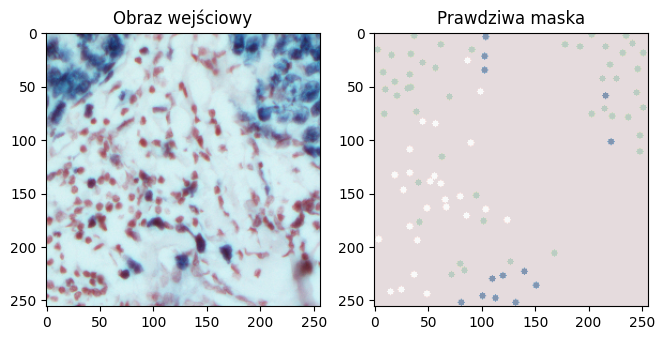

In [33]:
idx = random.randint(0, len(X_test) - 1)
test_img = X_test[idx:idx+1]  
true_mask = Y_test[idx] 
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='Reds', alpha=0.5) 
plt.imshow(true_mask[:, :, 1], cmap='Greens', alpha=0.5)
plt.imshow(true_mask[:, :, 2], cmap='Blues', alpha=0.5)  
plt.title("Prawdziwa maska")


1/1 [==============================] - 0s 19ms/step


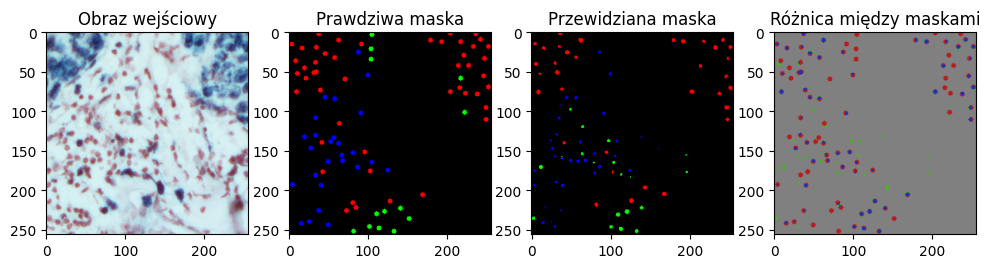

In [34]:
custom_colors = {
    0: [0, 0, 0],  # Tło - czarny
    1: [255, 0, 0], # Pozytywne - czerwony
    2: [0, 255, 0], # Negatywne - zielony
    3: [0, 0, 255]  # TIL - niebieski 
}

def compute_mask_difference(true_mask, pred_mask):
    diff_mask = np.zeros((*true_mask.shape, 3), dtype=np.uint8)

    true_mask_bin = (true_mask > 0).astype(np.uint8)
    pred_mask_bin = (pred_mask > 0).astype(np.uint8)

    # False Positives – Model przewidział, ale nie ma w ground truth (Zielony)
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 1)] = [71, 183, 29]

    # False Negatives – Model nie przewidział, ale ground truth istnieje (Czerwony)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 0)] = [183, 29, 29]

    # True Positives – Model dobrze przewidział (Niebieski)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 1)] = [29, 50, 183]

    # Tło – jeśli żaden z warunków nie został spełniony, ustaw szary kolor
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 0)] = [128, 128, 128]

    return diff_mask

def apply_custom_colors(mask, colors):
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in colors.items():
        colored_mask[mask == label] = color
    return colored_mask



test_img = X_test[idx:idx+1]  
true_mask = np.argmax(Y_test[idx], axis=-1)
pred_mask = np.argmax(model.predict(test_img)[0], axis=-1)


true_mask_colored = apply_custom_colors(true_mask, custom_colors)
pred_mask_colored = apply_custom_colors(pred_mask, custom_colors)
mask_diff_colored = compute_mask_difference(true_mask, pred_mask)

plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")

plt.subplot(1, 4, 2)
plt.imshow(true_mask_colored)
plt.title("Prawdziwa maska")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_colored)
plt.title("Przewidziana maska")

plt.subplot(1, 4, 4)
plt.imshow(mask_diff_colored)
plt.title("Różnica między maskami")
plt.show()


In [35]:
def test_model_performance(model, X_test, Y_test):

    Y_pred = model.predict(X_test)

    Y_pred_labels = np.argmax(Y_pred, axis=-1)  
    Y_test_labels = np.argmax(Y_test, axis=-1) 

    num_classes = Y_test.shape[-1]
    class_names = ["Tło", "Pozytywne", "Negatywne", "TIL" ]
    if num_classes != len(class_names):
        class_names = [f"Klasa {i}" for i in range(num_classes)]

    iou_scores = []
    for class_idx in range(num_classes):
        intersection = np.logical_and(Y_test_labels == class_idx, Y_pred_labels == class_idx).sum()
        union = np.logical_or(Y_test_labels == class_idx, Y_pred_labels == class_idx).sum()
        iou = intersection / union if union > 0 else 0
        iou_scores.append(iou)

    correct_classifications = np.sum(Y_test_labels == Y_pred_labels)
    total_pixels = np.prod(Y_test_labels.shape)
    classification_accuracy = correct_classifications / total_pixels

    print("\nWyniki modelu na zbiorze testowym:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: IoU = {iou_scores[i] * 100:.2f}%")

    print(f"\nOgólna dokładność klasyfikacji: {classification_accuracy * 100:.2f}%")

    return iou_scores, classification_accuracy


iou_results, accuracy = test_model_performance(model, X_test, Y_test)


22/22 [==============================] - 7s 316ms/step

Wyniki modelu na zbiorze testowym:
Tło: IoU = 97.61%
Pozytywne: IoU = 39.96%
Negatywne: IoU = 33.68%
TIL: IoU = 4.78%

Ogólna dokładność klasyfikacji: 97.62%


In [36]:
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment


def calculate_iou_objects_with_scores(true_mask, pred_mask, iou_threshold=0.3):
    results = {
        "IoU": {},
        "Detected Cells": {},
        "False Positives": {},
        "False Negatives": {},
        "True Positives": {},
        "Cost Matrix": {},
        "Hungarian Matches": {},
        "y_true_labels": {},
        "y_pred_scores": {} 
    }

    unique_classes = np.unique(true_mask)
    unique_classes = unique_classes[unique_classes > 0]

    for class_id in unique_classes:
        true_class_mask = (true_mask == class_id).astype(np.uint8)
        pred_class_mask = (pred_mask == class_id).astype(np.uint8)

        true_labeled = label(true_class_mask)
        pred_labeled = label(pred_class_mask)

        true_regions = regionprops(true_labeled)
        pred_regions = regionprops(pred_labeled)

        total_true_cells = len(true_regions)
        total_pred_cells = len(pred_regions)

        matched_cells = 0
        false_positives = 0
        false_negatives = total_true_cells
        intersection = 0
        union = 0

        y_true = []
        y_score = []

        if total_true_cells > 0 and total_pred_cells > 0:
            cost_matrix = np.ones((total_true_cells, total_pred_cells))

            for i, true_region in enumerate(true_regions):
                true_single_cell = (true_labeled == true_region.label)
                for j, pred_region in enumerate(pred_regions):
                    pred_single_cell = (pred_labeled == pred_region.label)
                    inter = np.logical_and(true_single_cell, pred_single_cell).sum()
                    uni = np.logical_or(true_single_cell, pred_single_cell).sum()
                    iou = inter / uni if uni > 0 else 0
                    if iou >= iou_threshold:
                        cost_matrix[i, j] = 1 - iou

            row_ind, col_ind = linear_sum_assignment(cost_matrix)

            matched_true = set()
            matched_pred = set()

            for i, j in zip(row_ind, col_ind):
                actual_iou = 1 - cost_matrix[i, j]
                if actual_iou >= iou_threshold:
                    matched_cells += 1
                    matched_true.add(i)
                    matched_pred.add(j)

                    true_single_cell = (true_labeled == true_regions[i].label)
                    pred_single_cell = (pred_labeled == pred_regions[j].label)

                    inter = np.logical_and(true_single_cell, pred_single_cell).sum()
                    uni = np.logical_or(true_single_cell, pred_single_cell).sum()

                    intersection += inter
                    union += uni
                    false_negatives -= 1

            false_positives = total_pred_cells - matched_cells

            results["Cost Matrix"][class_id] = cost_matrix.tolist()
            results["Hungarian Matches"][class_id] = list(zip(row_ind.tolist(), col_ind.tolist()))

        else:
            results["Cost Matrix"][class_id] = []
            results["Hungarian Matches"][class_id] = []

        
        for j, pred_region in enumerate(pred_regions):
            pred_cell = (pred_labeled == pred_region.label)
            best_iou = 0
            for i, true_region in enumerate(true_regions):
                true_cell = (true_labeled == true_region.label)
                inter = np.logical_and(pred_cell, true_cell).sum()
                uni = np.logical_or(pred_cell, true_cell).sum()
                iou = inter / uni if uni > 0 else 0
                best_iou = max(best_iou, iou)

            y_score.append(best_iou)
            y_true.append(1 if best_iou >= iou_threshold else 0)

        iou = (intersection / union) * 100 if union > 0 else 0
        results["IoU"][class_id] = round(iou, 2)
        results["Detected Cells"][class_id] = matched_cells
        results["False Positives"][class_id] = false_positives
        results["False Negatives"][class_id] = false_negatives
        results["True Positives"][class_id] = matched_cells

        results["y_true_labels"][class_id] = y_true
        results["y_pred_scores"][class_id] = y_score

    return results



In [37]:
def calculate_iou_dataset(y_true_all, y_pred_all, iou_threshold=0.3):
    aggregate = {
        "IoU": {},
        "Detected Cells": {},
        "False Positives": {},
        "False Negatives": {},
        "True Positives": {}
    }

    for true_mask, pred_mask in zip(y_true_all, y_pred_all):
        result = calculate_iou_objects_with_scores(np.argmax(true_mask, axis=-1), np.argmax(pred_mask, axis=-1), iou_threshold)

        for class_id in result["IoU"]:
            for key in aggregate:
                if class_id not in aggregate[key]:
                    aggregate[key][class_id] = 0

            aggregate["IoU"][class_id] += result["IoU"][class_id]  
            aggregate["Detected Cells"][class_id] += result["Detected Cells"][class_id]
            aggregate["False Positives"][class_id] += result["False Positives"][class_id]
            aggregate["False Negatives"][class_id] += result["False Negatives"][class_id]
            aggregate["True Positives"][class_id] += result["True Positives"][class_id]

    for class_id in aggregate["IoU"]:
        # Uśrednienie IoU po liczbie sparowanych masek
        detected = aggregate["Detected Cells"][class_id]
        aggregate["IoU"][class_id] = round(aggregate["IoU"][class_id] / detected, 2) if detected > 0 else 0.0

    return aggregate


In [38]:
results = calculate_iou_objects_with_scores(true_mask, pred_mask, iou_threshold=0.3)


df = pd.DataFrame({
    "Klasa": results["IoU"].keys(),
    "IoU (%)": results["IoU"].values(),
    "TP": results["True Positives"].values(),
    "FP": results["False Positives"].values(),
    "FN": results["False Negatives"].values(),
})

df.set_index("Klasa", inplace=True)


print(df)


       IoU (%)  TP  FP  FN
Klasa                     
1        55.29  28   6  19
2        60.22   6  14   7
3        40.36  13  21  11


In [19]:
y_pred_all = model.predict(X_test)

dataset_results = calculate_iou_dataset(Y_test, y_pred_all, iou_threshold=0.3)

22/22 [==============================] - 7s 326ms/step


In [20]:
import pandas as pd

df = pd.DataFrame({
    "Klasa": dataset_results["IoU"].keys(),
    "IoU (%)": dataset_results["IoU"].values(),
    "TP": dataset_results["True Positives"].values(),
    "FP": dataset_results["False Positives"].values(),
    "FN": dataset_results["False Negatives"].values(),
})

df.set_index("Klasa", inplace=True)

print(df)

       IoU (%)     TP     FP     FN
Klasa                              
1         3.61  10211   4715   5465
2         1.86  18150  10310  14077
3        10.34     97    369   1239


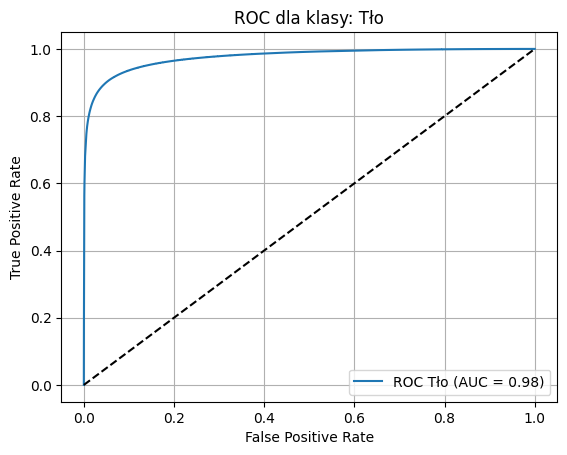

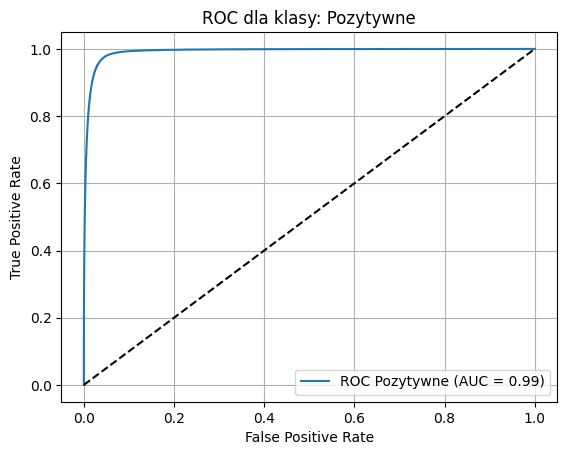

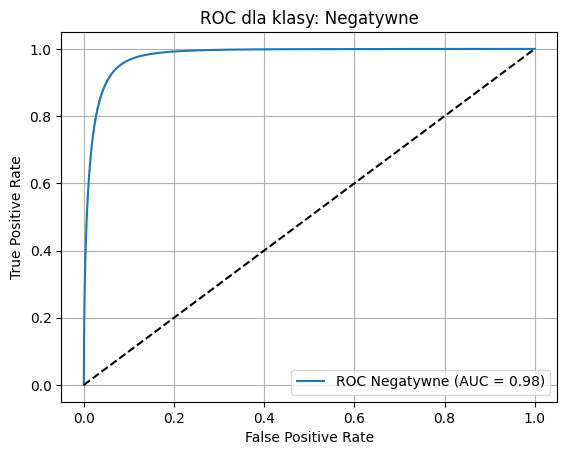

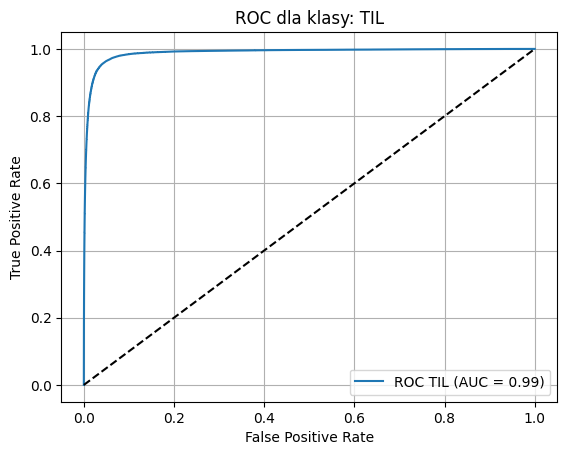

In [21]:
def plot_roc_for_class(y_true, y_score, class_index, class_name, threshold=0.2):
    y_true_class = (y_true[..., class_index].flatten() > threshold).astype(int)
    y_score_class = y_score[..., class_index].flatten()

    fpr, tpr, _ = roc_curve(y_true_class, y_score_class)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC {class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC dla klasy: {class_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

for i, label_name in enumerate(["Tło", "Pozytywne", "Negatywne", "TIL"]):
    plot_roc_for_class(Y_test, y_pred_all, class_index=i, class_name=label_name)



In [39]:
for class_id, name in zip([1, 2, 3], ["Pozytywne", "Negatywne", "TIL"]):
    tp = dataset_results["True Positives"][class_id]
    fp = dataset_results["False Positives"][class_id]
    fn = dataset_results["False Negatives"][class_id]
    tn = None  

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    print(f"\nKlasa: {name}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")



Klasa: Pozytywne
  Precision: 0.6841
  Recall:    0.6514
  F1-score:  0.6673

Klasa: Negatywne
  Precision: 0.6377
  Recall:    0.5632
  F1-score:  0.5982

Klasa: TIL
  Precision: 0.2082
  Recall:    0.0726
  F1-score:  0.1077


In [ ]:
from sklearn.metrics import confusion_matrix

def pixel_metrics(y_true, y_pred, num_classes=4):

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    metrics = {}

    for class_id in range(1, num_classes):  # pomijamy tło (klasa 0)
        # binarne maski dla danej klasy
        y_true_bin = (y_true_flat == class_id).astype(int)
        y_pred_bin = (y_pred_flat == class_id).astype(int)

        # TN, FP, FN, TP
        tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1]).ravel()

        # metryki
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        specificity = tn / (tn + fp + 1e-8)

        metrics[class_id] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "specificity": specificity
        }

    return metrics


In [42]:
y_true_argmax = np.argmax(Y_test, axis=-1)
y_pred_argmax = np.argmax(model.predict(test_ds), axis=-1)

metrics_pix = pixel_metrics(y_true_argmax, y_pred_argmax)

for class_id, name in zip([1, 2, 3], ["Pozytywne", "Negatywne", "TIL"]):
    m = metrics_pix[class_id]
    print(f"\nKlasa: {name}")
    print(f"  Precision:   {m['precision']:.4f}")
    print(f"  Recall:      {m['recall']:.4f}")
    print(f"  F1-score:    {m['f1']:.4f}")
    print(f"  Specificity: {m['specificity']:.4f}")


44/44 [==============================] - 7s 167ms/step

Klasa: Pozytywne
  Precision:   0.7222
  Recall:      0.4722
  F1-score:    0.5710
  Specificity: 0.9982

Klasa: Negatywne
  Precision:   0.6804
  Recall:      0.4002
  F1-score:    0.5039
  Specificity: 0.9961

Klasa: TIL
  Precision:   0.5388
  Recall:      0.0499
  F1-score:    0.0913
  Specificity: 1.0000


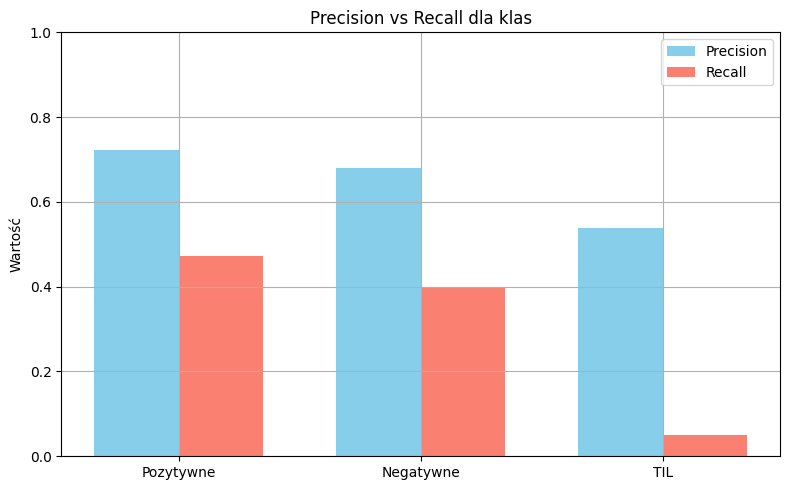

In [44]:
labels = ['Pozytywne', 'Negatywne', 'TIL']
precision = [metrics_pix[i]['precision'] for i in range(1, 4)]
recall = [metrics_pix[i]['recall'] for i in range(1, 4)]

x = np.arange(len(labels))
width = 0.35

# Tworzenie wykresu
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, precision, width, label='Precision', color='skyblue')
ax.bar(x + width/2, recall, width, label='Recall', color='salmon')

ax.set_ylabel('Wartość')
ax.set_title('Precision vs Recall dla klas')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
